### Import Python Library

In [1]:
import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.plugins.adjoint as tda
import numpy as np
import jax.numpy as jnp
import jax

np.random.seed(2) # to get same random results

### Setup Parameters 

In [2]:
# material 
n_si = 3.49
n_sio2 = 1.45
n_air = 1

# wavelength and frequency
wavelength = 1.55
freq0 = td.C_0 / wavelength
freqw = freq0 / 10
run_time = 50 / freqw

# design region size
lx = 2.8
ly = 2.8
lz = td.inf

# waveguide information
wg_width = 0.3
wg_length = 1.5
wg_spacing = 0.8

buffer = 1.5

# simulation size
Lx = lx + wg_length * 2
Ly = ly + buffer * 2
Lz = 0.0

# fabrication constraint
radius = 0.2
beta = 30

# resolution 
min_steps_per_wvl = 25

### Define design geometries

In [3]:
wg_in = td.Structure(
    geometry = td.Box(
        center=(-Lx/2, 0, 0),
        size = (wg_length *2, wg_width, lz),
    ), 
    medium=td.Medium(permittivity=n_si**2)
)

wg_top = td.Structure(
    geometry= td.Box(
        center=(+Lx/2, +wg_width/2 + wg_spacing/2, 0),
        size=(wg_length*2, wg_width, lz),
    ),
    medium = td.Medium(permittivity=n_si**2)
)

wg_bot = td.Structure(
    geometry=td.Box(
        center = (+Lx/2, -wg_width/2 - wg_spacing/2, 0),
        size=(wg_length*2, wg_width, lz)
    ),
    medium= td.Medium(permittivity=n_si**2)
)

# field monitor
fld_mnt = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field"
)

# design region
nx = 55
ny = 55

design_region_geo = tda.JaxBox(
    size = (lx, ly, lz),
    center=(0, 0, 0)
)

design_region_dl = lx / nx

### 

### Pixellated region design using filtering and projection methods

In [6]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter

conic_filter = ConicFilter(radius = radius, design_region_dl= design_region_dl)

def tanh_projection(x, beta, eta = 0.5):
    tanhbn = jnp.tanh(beta * eta)
    num = tanhbn + jnp.tanh(beta * (x - eta))
    den = tanhbn + jnp.tanh(beta * (1 - eta))
    return num / den

def filter_project(x, beta, eta = 0.5):
    x = conic_filter.evaluate(x)
    proj_field = tanh_projection(x, beta = beta, eta = eta)
    proj_field = (jnp.fliplr(proj_field) + proj_field) / 2 
    return proj_field

num_projections = 2

def pre_process(params, beta):
    for _ in range(num_projections):
        params = filter_project(params, beta=beta)
    return params

def make_eps(params, beta):
    params = pre_process(params, beta=beta)
    eps_values = 1 + (n_si**2 - 1) * params
    return eps_values

def make_custom_medium(params, beta):
    eps = make_eps(params, beta).reshape((nx ,ny, 1, 1))
    eps = jnp.where(eps < 1, 1, eps)
    eps = jnp.where(eps > n_si**2, n_si**2, eps)

    xs = list(jnp.linspace(-lx/2, lx/2, nx))
    ys = list(jnp.linspace(-ly/2, ly/2, ny))
    zs = [0]
    freqs = [freq0]
    coords = dict(x = xs, y = ys, z = zs, f = freqs)

    eps_dataset = tda.JaxDataArray(values = eps, coords = coords)

    medium = tda.JaxCustomMedium(
        eps_dataset = tda.JaxPermittivityDataset(
            eps_xx = eps_dataset,
            eps_yy=eps_dataset,
            eps_zz=eps_dataset,
        )
    )

    struct = tda.JaxStructure(
        geometry = design_region_geo,
        medium = medium, 
    )

    return struct

### Define simulation

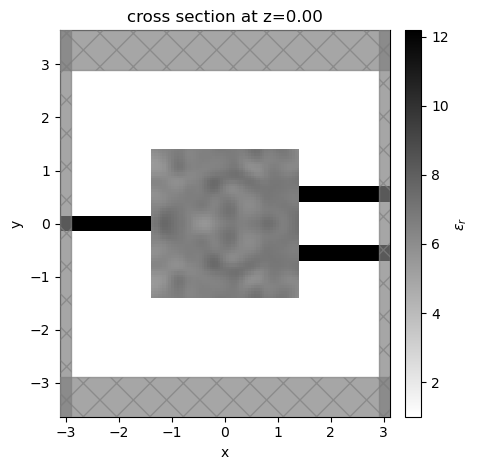

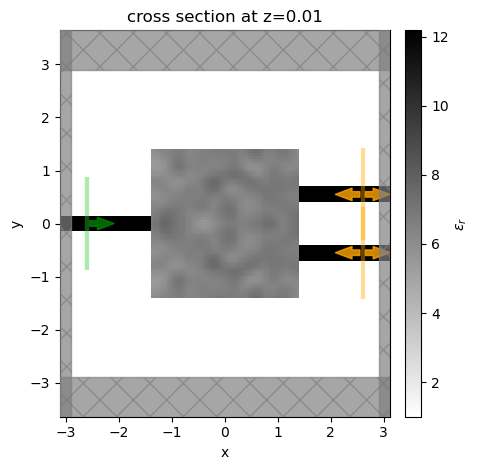

In [10]:
from tidy3d.plugins.mode import ModeSolver

def make_sim_base(params, beta):
    input_struct = make_custom_medium(params, beta = beta)

    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=wavelength),
        structures=[wg_in, wg_top, wg_bot],
        monitors=[fld_mnt],
        input_structures=[input_struct],
        boundary_spec=td.BoundarySpec.pml(x = True, y = True, z = True if Lz else False),
        run_time=run_time,
    )

params0 = np.random.random((nx, ny))
sim_base = make_sim_base(params0, beta=1)

ax = sim_base.plot_eps(z = 0, monitor_alpha=0.0)

# Add mode source and mode monitors 
mode_index = 0
mode_size = (0, 1.8*wg_spacing + wg_width, max([Lz, lz, 3]))
mode_spec = td.ModeSpec(num_modes=mode_index + 1)

mode_src = td.ModeSource(
    source_time= td.GaussianPulse(freq0=freq0, fwidth = freqw),
    center = [-Lx/2 + 0.2*wg_length, 0, 0],
    size = mode_size,
    mode_index= mode_index,
    mode_spec= mode_spec,
    direction= "+",
)

mnt_top = td.ModeMonitor(
    center = [Lx/2 - 0.2*wg_length, +wg_width/2 + wg_spacing/2, 0],
    size = mode_size,
    freqs=[freq0],
    mode_spec= mode_spec,
    name = "mode_top",
)

mnt_bot = td.ModeMonitor(
    center = [Lx/2 - 0.2*wg_length, -wg_width/2 - wg_spacing/2, 0],
    size = mode_size,
    freqs=[freq0],
    mode_spec= mode_spec,
    name = "mode_bot",
)

def make_sim(params, beta):
    
    sim_base = make_sim_base(params, beta = beta)
    return sim_base.updated_copy(
        output_monitors = [mnt_top, mnt_bot],
        sources = [mode_src]
    )


sim = make_sim(params0, beta=1)
ax = sim.plot_eps(z=0.01)
plt.show()

### Objective function

In [11]:
from tidy3d.plugins.adjoint.utils.penalty import ErosionDilationPenalty

mnt_names = dict(top="mode_top", bot="mode_bot")

def measure_power(sim_data) -> float:
    """Extract power from simulation data."""

    def get_power(mnt_key: str) -> float:
        """Get the power at monitor 'mnt_key' at frequency 'freq_key' (both either 'top' or 'bot')."""
        mnt_name = mnt_names[mnt_key]
        freq = freq0
        mnt_data = sim_data[mnt_name]
        amp = mnt_data.amps.sel(direction="+", mode_index=0, f=freq)        
        return jnp.abs(amp) ** 2

    power_max = get_power("top") + get_power("bot")
    return power_max / 2.0


def penalty(params, beta) -> float:
    """Penalty based on the amount of change after erosion and dilation of structures."""
    params = pre_process(params, beta=beta)

    ed_penalty = ErosionDilationPenalty(length_scale=radius, pixel_size=design_region_dl)
    return ed_penalty.evaluate(params)

def objective(params, beta, verbose=False) -> float:
    sim = make_sim(params, beta=beta)
    sim_data = tda.web.run(sim, task_name="Splitter", verbose=verbose)
    power = measure_power(sim_data)
    J = power - penalty(params, beta=beta)
    return J, sim_data

### Inverse Design

In [12]:
grad_fn = jax.value_and_grad(objective, has_aux=True)
(J, sim_data), grad = grad_fn(params0, beta=1, verbose=True)

16:25:51 CEST Created task 'WDM_MULTIFREQ' with task_id                         
              'fdve-77e1bc73-aa6c-409f-8b17-71a73672b331' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=585063;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=105056;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\taskId]8;;\]8;id=585063;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\=]8;;\]8;id=325635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\fdve]8;;\]8;id=585063;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\-77e1bc73-aa]8;;\
              ]8;id=585063;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\6c-409f-8b17-71a73672b331']8;;\.

Output()

Output()

16:25:56 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

16:26:02 CEST status = preprocess

16:26:03 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

16:26:04 CEST running solver

Output()

16:26:11 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

16:26:14 CEST status = success

              View simulation result at                                         
              ]8;id=557121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=472232;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\taskId]8;;\]8;id=557121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\=]8;;\]8;id=7161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\fdve]8;;\]8;id=557121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\-77e1bc73-aa]8;;\
              ]8;id=557121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e1bc73-aa6c-409f-8b17-71a73672b331\6c-409f-8b17-71a73672b331']8;;\.

Output()

16:26:21 CEST loading simulation from simulation_data.hdf5

16:26:22 CEST Created task 'WDM_MULTIFREQ_adj' with task_id                     
              'fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=289051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=428340;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\taskId]8;;\]8;id=289051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\=]8;;\]8;id=905678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\fdve]8;;\]8;id=289051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\-86f35503-eb]8;;\
              ]8;id=289051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\c8-463c-aa07-511d9cbd7abe']8;;\.

Output()

Output()

16:26:27 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

16:26:32 CEST status = preprocess

16:26:35 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

16:26:44 CEST early shutoff detected at 32%, exiting.

              status = postprocess

Output()

16:26:47 CEST status = success

              View simulation result at                                         
              ]8;id=436815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=915077;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\taskId]8;;\]8;id=436815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\=]8;;\]8;id=602582;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\fdve]8;;\]8;id=436815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\-86f35503-eb]8;;\
              ]8;id=436815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86f35503-ebc8-463c-aa07-511d9cbd7abe\c8-463c-aa07-511d9cbd7abe']8;;\.

Output()

### Optimization

In [13]:
import optax

# we know that the source fwidth will be set automatically due to multi-freq adjoint, so suppress warnings
td.config.logging_level = "ERROR"

# hyperparameters
num_steps = 50
learning_rate = 5e-2
beta_min = 1
beta_max = 30

# initialize adam optimizer with starting parameters
params = params0
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
params_history = [params0]
data_history = []
beta_history = []

for i in range(num_steps):

    perc_done = i / (num_steps - 1)
    beta_i = beta_min * (1 - perc_done) + beta_max * perc_done
    
    # compute gradient and current objective funciton value
    (value, data), gradient = grad_fn(params, beta=beta_i)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tbeta = {beta_i:.2f}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # keep params between 0 and 1
    params = jnp.minimum(1.0, params)
    params = jnp.maximum(0.0, params)

    # save history
    Js.append(value)
    params_history.append(params)
    beta_history.append(beta_i)
    data_history.append(data)

step = 1
	J = -8.9545e-01
	beta = 1.00
	grad_norm = 1.4817e-01
step = 2
	J = -7.2821e-01
	beta = 1.59
	grad_norm = 1.5958e-01
step = 3
	J = -5.8451e-01
	beta = 2.18
	grad_norm = 2.5131e-01
step = 4
	J = -6.7122e-01
	beta = 2.78
	grad_norm = 5.2083e-01
step = 5
	J = -7.1729e-01
	beta = 3.37
	grad_norm = 5.1368e-01
step = 6
	J = -6.2404e-01
	beta = 3.96
	grad_norm = 5.5133e-01
step = 7
	J = -5.8457e-01
	beta = 4.55
	grad_norm = 3.2467e-01
step = 8
	J = -4.6494e-01
	beta = 5.14
	grad_norm = 3.1775e-01
step = 9
	J = -3.4649e-01
	beta = 5.73
	grad_norm = 2.2435e-01
step = 10
	J = -3.0879e-01
	beta = 6.33
	grad_norm = 4.0545e-01
step = 11
	J = -2.2909e-01
	beta = 6.92
	grad_norm = 6.0148e-01
step = 12
	J = -1.6796e-01
	beta = 7.51
	grad_norm = 3.5135e-01
step = 13
	J = -1.5383e-01
	beta = 8.10
	grad_norm = 3.5539e-01
step = 14
	J = -1.2748e-01
	beta = 8.69
	grad_norm = 3.0417e-01
step = 15
	J = -5.5180e-02
	beta = 9.29
	grad_norm = 3.6265e-01
step = 16
	J = -2.9246e-03
	beta = 9.88
	grad_nor

### Result

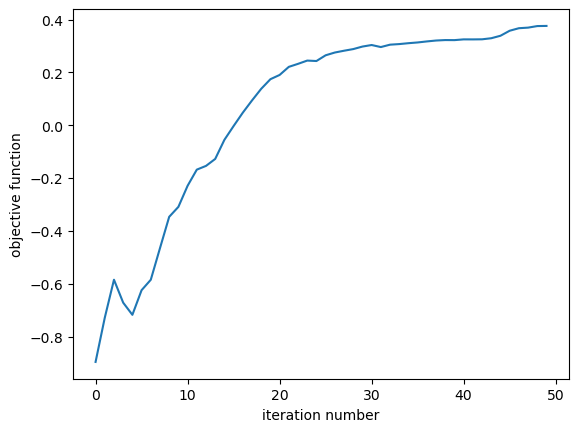

In [14]:
plt.plot(Js)
plt.xlabel('iteration number')
plt.ylabel('objective function')
plt.show()

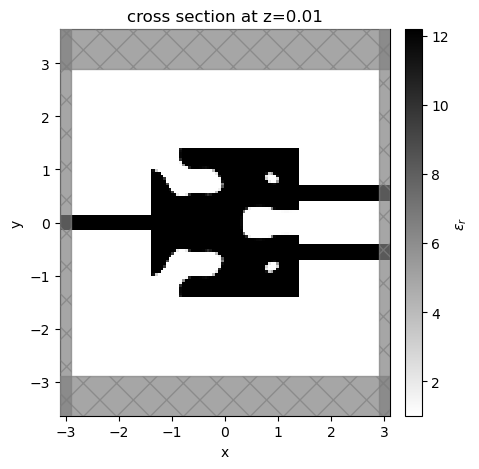

In [15]:
sim_data_final = data_history[-1]
sim_final = sim_data_final.simulation

ax = sim_final.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0)

### Visulizing Field

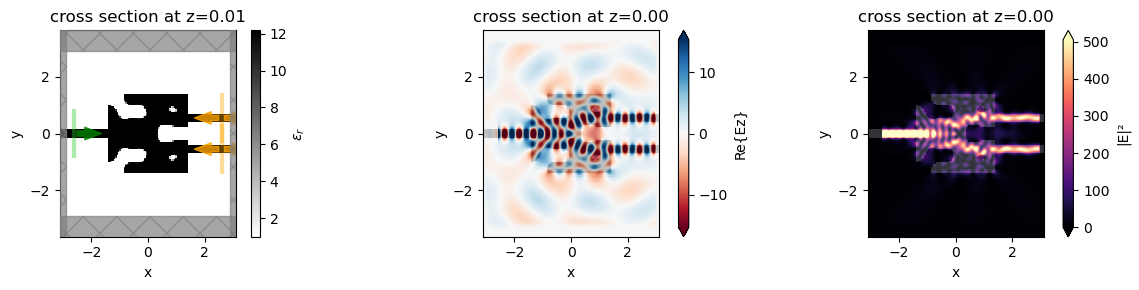

In [18]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
sim_final.plot_eps(z=0.01, ax=ax0)
ax1 = sim_data_final.plot_field("field", "Ez", z=0, ax=ax1)
ax2 = sim_data_final.plot_field("field", "E", "abs^2", z=0, ax=ax2)

### Animation

In [23]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, (ax1, ax2) = fig, axes = plt.subplots(1, 2, tight_layout=False, figsize=(9, 4))

def animate(i):

    sim_data_i = data_history[i]

    sim_i = sim_data_i.simulation
    sim_i.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0, ax=ax1)
    ax1.set_aspect('equal')

    wvl = 1000 * td.C_0 / freq0
    int_i = sim_data_i.get_intensity("field").sel(f = freq0)
    int_i.squeeze().plot.pcolormesh(x='x', y='y', ax=ax2, add_colorbar=False, cmap="magma", vmax=1000)
    ax2.set_aspect('equal')
    ax2.set_title(f"wavelength = {int(wvl)} nm")
    
# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(data_history))
plt.close()

In [24]:
HTML(ani.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [26]:
ani.save('splliter.gif', fps=60)

<Figure size 640x480 with 0 Axes>